In [6]:
import sys

sys.path.append('../..')

import torch
import pytorch_lightning as pl
from pytorch_lightning.utilities.model_summary import ModelSummary

from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import random
import tickle
from tqdm import tqdm
from scipy.signal import resample

from VISTorchUtils import WaveLoss
from VISDataPoint import VISDataPointV3

from IPython.display import Audio

In [2]:
class AudioAutoEncoderConv(pl.LightningModule):
    def __init__(self, input_size=48000):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, 512, stride=16, padding=8, padding_mode='replicate'),
            nn.BatchNorm1d(16),
            nn.RReLU(), 
            nn.Conv1d(16, 64, 256, stride=4, padding=2, padding_mode='replicate'),
            nn.BatchNorm1d(64), 
            nn.RReLU(), 
            nn.Conv1d(64, 8, 64, stride=2, padding=1, padding_mode='replicate'),
            nn.BatchNorm1d(8))        
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 64, 64, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.RReLU(), 
            nn.ConvTranspose1d(64, 16, 256, stride=4, padding=1),
            nn.BatchNorm1d(16),
            nn.RReLU(), 
            nn.ConvTranspose1d(16, 1, 512, stride=16, padding=8))
        
        # self.loss_fn = nn.MSELoss()
        self.loss_fn = WaveLoss()

    def forward(self, wav):
        emb = self.encoder(wav.unsqueeze(1))
        reconstructed = self.decoder(emb).squeeze()
        return reconstructed
        
    def get_encoding(self, wav):
        return self.encoder(wav.unsqueeze(1)).flatten(start_dim=1)

    def get_reconstructed(self, emb):
        return self.decoder(emb.reshape(-1, 8, 310)).squeeze()
    
    def training_step(self, batch, batch_idx):
        wav = batch
        out = self(wav)
        loss = self.loss_fn(out, wav)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        wav = batch
        out = self(wav)
        loss = self.loss_fn(out, wav)
        self.log('val_loss',  loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 1e-3)
        return optimizer 

In [32]:
class SplitAudioAE(pl.LightningModule):
    
    def __init__(self, split_freq:int=5000) -> None:
        super().__init__()
        self.lfAE = AudioAutoEncoderConv()
        self.hfAE = AudioAutoEncoderConv()
        self.splitFreq = split_freq

        self.loss_fn = nn.MSELoss()

    def _splitWaves(self, waves):
        freq_data = torch.fft.rfft(waves)
       
        lf = torch.zeros_like(freq_data)
        lf[:,:self.splitFreq] = freq_data[:,:self.splitFreq]

        hf = torch.zeros_like(freq_data)
        hf[:,self.splitFreq:] = freq_data[:,self.splitFreq:]

        lfWave = torch.fft.irfft(lf)
        hfWave = torch.fft.irfft(hf)

        return lfWave, hfWave
    
    def _mergeWaves(self, lfWave, hfWave):
        
        lf = torch.fft.rfft(lfWave)
        hf = torch.fft.rfft(hfWave)

        # Mask for assistance
        lf[:, :self.splitFreq] = 0
        hf[:, self.splitFreq:] = 0

        freq_data = lf + hf
        out = torch.fft.irfft(freq_data)
        return out
    
    def getEmbedding(self, X):
        lf, hf = self._splitWaves(X, self.splitFreq)
        lfEmb = self.lfAE.get_encoding(lf)
        hfEmb = self.hfAE.get_encoding(hf)
        return torch.cat([lfEmb, hfEmb], dim=1)
    
    def reconstructWave(self, emb):
        lfEmb, hfEmb = torch.split(emb, emb.shape[1]//2, dim=1)
        lfWave = self.lfAE.get_reconstructed(lfEmb)
        hfWave = self.hfAE.get_reconstructed(hfEmb)
        return self._mergeWaves(lfWave, hfWave)

    def forward(self, X):
        lf, hf = self._splitWaves(X)
        lfOut = self.lfAE(lf)
        hfOut = self.hfAE(hf)
        out = self._mergeWaves(lfOut, hfOut)
        return out
    
    def training_step(self, batch, batch_idx):
        wav = batch
        out = self(wav)
        loss = self.loss_fn(out, wav)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        wav = batch
        out = self(wav)
        loss = self.loss_fn(out, wav)
        self.log('val_loss',  loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 1e-3)
        return optimizer 


In [21]:
class AudioDataset(Dataset):
    def __init__(self, root: str, sr: int=96000):
        self.root = root
        self.files = glob.glob(os.path.join(self.root, '*.tkl'))
        self.sr = sr
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        dataPoint: VISDataPointV3 = tickle.load(self.files[idx])
        wav = torch.tensor(dataPoint.wav, dtype=torch.float32)
        return wav

In [22]:
trainDataset = AudioDataset('/scratch/vis_data_v3/train/')
valDataset = AudioDataset('/scratch/vis_data_v3/test/')

In [23]:
BATCH_SIZE = 8
NUM_WORKERS = 2

In [24]:
trainDataLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valDataLoader = DataLoader(valDataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [33]:
model = SplitAudioAE()

In [34]:
logger = pl.loggers.TensorBoardLogger('tb_logs', name='split_audio_autoencoder')
checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    dirpath="model_weights",
    filename="split-ae-{epoch:02d}-{val_loss:.2f}",
)
trainer = pl.Trainer(accelerator='gpu', devices=1,
                     max_epochs=15, logger=logger,
                     callbacks=[checkpoint_callback])
torch.set_float32_matmul_precision('medium')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [35]:
trainer.fit(model, trainDataLoader, valDataLoader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                 | Params
-------------------------------------------------
0 | lfAE    | AudioAutoEncoderConv | 606 K 
1 | hfAE    | AudioAutoEncoderConv | 606 K 
2 | loss_fn | MSELoss              | 0     
-------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.854     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home2/dhruv.kapur/anaconda3/envs/torch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home2/dhruv.kapur/anaconda3/envs/torch/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [37]:
wavs = next(iter(trainDataLoader))
wavs_pred = model(wavs.to('cuda'))

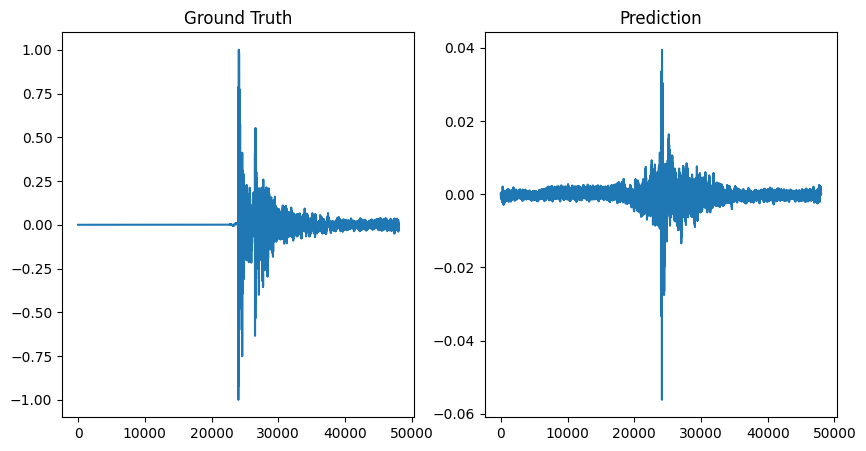

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].set_title('Ground Truth')
axs[0].plot(wavs[0].detach().cpu())
axs[1].set_title('Prediction')
axs[1].plot(wavs_pred[0].squeeze().detach().cpu())
plt.show()

In [39]:
freq_data = torch.fft.rfft(wavs[0])
freq_data_pred = torch.fft.rfft(wavs_pred[0].squeeze())

/home2/dhruv.kapur/anaconda3/envs/torch/lib/python3.9/site-packages/torch/_tensor.py:958: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


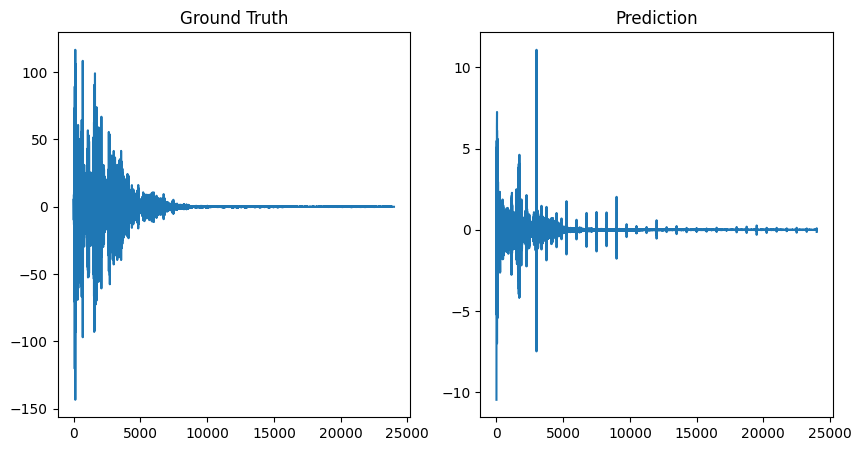

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].set_title('Ground Truth')
axs[0].plot(freq_data.detach().cpu())
axs[1].set_title('Prediction')
axs[1].plot(freq_data_pred.squeeze().detach().cpu())
plt.show()

In [42]:
Audio(wavs[0].detach().cpu(), rate=96000)

In [43]:
Audio(wavs_pred[0].squeeze().detach().cpu(), rate=96000)